In [5]:
from __future__ import division

import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import matplotlib as mpl
from wyrm import processing as proc
from wyrm.types import Data
from wyrm import plot
from wyrm.io import load_bcicomp3_ds1

import scipy.signal as signal
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif


## Mat

In [6]:
DATA_DIR = 'data/mat/'
TRUE_LABELS = 'data/raw/test/test_label.txt'

In [7]:
dat_train, dat_test = load_bcicomp3_ds1(DATA_DIR)

true_labels = np.loadtxt(TRUE_LABELS).astype('int')
true_labels[true_labels == -1] = 0

In [8]:
dat_train.axes[0]

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [9]:
def plot_csp_pattern(a):
    # get symmetric min/max values for the color bar from first and last column of the pattern
    maxv = np.max(np.abs(a[:, [0, -1]]))
    minv = -maxv
    
    im_args = {'interpolation' : 'None', 
           'vmin' : minv, 
           'vmax' : maxv
           }

    # plot
    ax1 = plt.subplot2grid((1,11), (0,0), colspan=5)
    ax2 = plt.subplot2grid((1,11), (0,5), colspan=5)
    ax3 = plt.subplot2grid((1,11), (0,10))

    ax1.imshow(a[:, 0].reshape(8, 8), **im_args)
    ax1.set_title('Pinky')

    ax = ax2.imshow(a[:, -1].reshape(8, 8), **im_args)
    ax2.set_title('Tongue')

    plt.colorbar(ax, cax=ax3)
    plt.tight_layout()


def preprocess(data, filt=None):
    dat = data.copy()
    fs_n = dat.fs / 2
    
    b, a = proc.signal.butter(5, [13 / fs_n], btype='low')
    dat = proc.filtfilt(dat, b, a)
    
    b, a = proc.signal.butter(5, [9 / fs_n], btype='high')
    dat = proc.filtfilt(dat, b, a)
    
    dat = proc.subsample(dat, 50)

    if filt is None:
        filt, pattern, _ = proc.calculate_csp(dat)
        plot_csp_pattern(pattern)
    dat = proc.apply_csp(dat, filt)
    
    dat = proc.variance(dat)
    dat = proc.logarithm(dat)
    return dat, filt

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Bofu Zou\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Bofu Zou\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findf

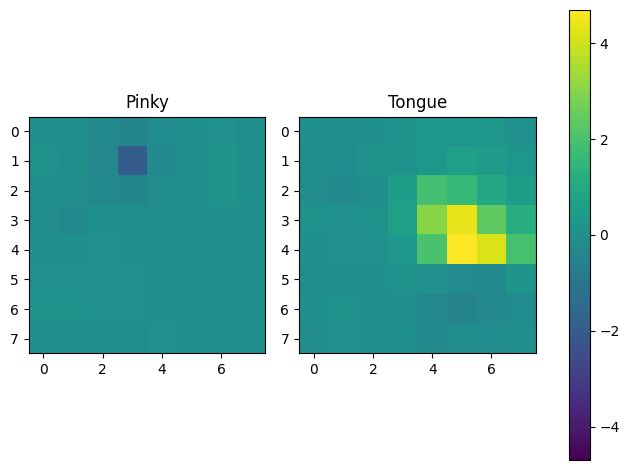

In [10]:
fv_train, filt = preprocess(dat_train)
fv_test, _ = preprocess(dat_test, filt)

In [11]:
fv_train.data.shape

(278, 2)

In [12]:
fv_train.data

array([[ 5.53450689e-01, -1.95317282e+00],
       [-2.63588700e-01,  3.15613321e-01],
       [ 8.33234784e-01, -1.76008848e-01],
       [ 2.81223528e-01, -8.82594008e-01],
       [-1.42330169e-01, -4.46037455e-01],
       [-1.02759817e-03, -1.90689293e-01],
       [ 4.63008095e-01,  1.27328927e-01],
       [ 1.49462427e+00, -2.29095490e+00],
       [ 5.35875175e-01,  5.92846976e-01],
       [ 5.91487373e-01, -1.11994364e+00],
       [ 1.54792501e-01, -1.47014415e+00],
       [ 5.78915512e-01, -8.03542105e-02],
       [-2.93084157e-01,  1.58072705e-01],
       [ 9.39154380e-02, -1.61079609e+00],
       [-1.44451826e-01,  2.74496272e-01],
       [ 1.06483521e+00, -1.00740057e-01],
       [ 2.51011337e-01, -8.90744265e-01],
       [ 8.11717018e-01, -1.10698771e-01],
       [ 1.12670217e+00, -5.27959539e-01],
       [ 4.92786025e-01, -9.39680564e-01],
       [-7.78737144e-02,  1.52052813e-01],
       [ 5.39687867e-01, -8.50836514e-01],
       [-2.34191568e-01, -2.15209066e-01],
       [ 5.

In [13]:
cfy = proc.lda_train(fv_train)
result = proc.lda_apply(fv_test, cfy)
result = (np.sign(result) + 1) / 2
print('LDA Accuracy %.2f%%' % ((result == true_labels).sum() / len(result)))

LDA Accuracy 0.94%


## CSSD

In [14]:
fv_train.data.shape

(278, 2)

In [15]:
X_train = dat_train.data
X_test = dat_test.data
y_train = dat_train.axes[0]

In [16]:
selector = SelectKBest(score_func=f_classif)
features_train_selected = selector.fit_transform(fv_train.data, y_train)
features_test_selected = selector.transform(fv_test.data)

c:\Users\Bofu Zou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=2. All the features will be returned.
  warnings.warn(


In [17]:
# ----------------------------
# Classification with a Linear SVM
# ----------------------------
clf = SVC(kernel='linear')
clf.fit(features_train_selected, y_train)

SVC(kernel='linear')

In [18]:
# Predict on test data
y_pred = clf.predict(features_test_selected)
print("Predicted test labels:", y_pred)

Predicted test labels: [1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1
 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1]


In [19]:
# Compute accuracy
accuracy = np.mean(y_pred == true_labels)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 93.00%


In [61]:
import scipy as sp

def adaptive_csp(epo, prev_covs=None, classes=None, lambda_=0.9, adaptive=True):
    """
    Adaptive CSP: Compute spatial filters based on updated covariance matrices.
    When adaptive=False, it computes covariances in the classic way.
    
    Parameters
    ----------
    epo : epoched Data object with dimensions (class, time, channel)
    prev_covs : dict or None, previous covariance matrices with keys 'c1' and 'c2'
    classes : list of two ints, optional
    lambda_ : forgetting factor (0 < lambda_ < 1)
    adaptive : bool, if True, update covariances recursively; if False, compute classic covariances
    
    Returns
    -------
    v : 2d array, sorted spatial filters
    a : 2d array, sorted spatial patterns
    d : 1d array, sorted eigenvalues
    covs : dict with keys 'c1' and 'c2'
    """
    n_channels = epo.data.shape[-1]
    
    # Determine class indices
    if classes is None:
        unique_classes = np.unique(epo.axes[0])
        assert len(unique_classes) >= 2, "Not enough different classes in data."
        cidx1 = unique_classes[0]
        cidx2 = unique_classes[1]
    else:
        assert len(classes) >= 2 and classes[0] in epo.axes[0] and classes[1] in epo.axes[0], \
            "Provided classes not found in data."
        cidx1, cidx2 = classes[0], classes[1]
    
    # Select epochs for each class (using your proc.select_epochs)
    epoc1 = proc.select_epochs(epo, np.nonzero(epo.axes[0] == cidx1)[0], classaxis=0)
    epoc2 = proc.select_epochs(epo, np.nonzero(epo.axes[0] == cidx2)[0], classaxis=0)
    
    # Reshape epochs into (observations, channels)
    x1 = epoc1.data.reshape(-1, n_channels)
    x2 = epoc2.data.reshape(-1, n_channels)
    
    # Compute new covariance matrices (classic)
    new_c1 = np.cov(x1.transpose())
    new_c2 = np.cov(x2.transpose())
    
    # Choose adaptive update if requested
    if adaptive:
        if prev_covs is None:
            updated_c1 = new_c1
            updated_c2 = new_c2
        else:
            updated_c1 = lambda_ * prev_covs["c1"] + (1 - lambda_) * new_c1
            updated_c2 = lambda_ * prev_covs["c2"] + (1 - lambda_) * new_c2
    else:
        updated_c1 = new_c1
        updated_c2 = new_c2
    
    # Solve generalized eigenvalue problem:
    d, v = sp.linalg.eig(updated_c1 - updated_c2, updated_c1 + updated_c2)
    d = d.real  # only the real part
    indx = np.argsort(d)[::-1]  # sort in descending order
    d = d.take(indx)
    v = v.take(indx, axis=1)
    a = sp.linalg.inv(v).transpose()
    
    covs = {"c1": updated_c1, "c2": updated_c2}
    return v, a, d, covs


In [62]:
import numpy as np

# --- Adaptive CSP filtering on training data ---
# Compute adaptive CSP filters on training data
v, a, d, covs = adaptive_csp(dat_train)
filt = {'filters': v, 'patterns': a, 'covs': covs, 'd': d}

# ----- Select a fixed subset of spatial filters -----
selected_filters = np.hstack((filt['filters'][:, :5], filt['filters'][:, -5:]))

# Apply the computed spatial filters (selected subset) to the training data
dat_train_filtered = proc.apply_spatial_filter(dat_train, selected_filters)

# --- Feature extraction on training data ---
# Compute variance and then logarithm to get the final feature vectors for each trial
fv_train = proc.variance(dat_train_filtered)
fv_train = proc.logarithm(fv_train)

# --- Train the LDA classifier using Wyrm's functions ---
cfy = proc.lda_train(fv_train)

# --- Process the test data using the training filters ---
# Note: We do not update or recompute the filters on test data;
# we simply apply the same 'selected_filters' from training.
dat_test_filtered = proc.apply_spatial_filter(dat_test, selected_filters)

# --- Feature extraction on testing data ---
fv_test = proc.variance(dat_test_filtered)
fv_test = proc.logarithm(fv_test)

# --- Apply the trained LDA classifier on test features ---
result = proc.lda_apply(fv_test, cfy)
result = (np.sign(result) + 1) / 2

# Evaluate accuracy (make sure 'true_labels' corresponds to your test labels)
accuracy = (result == true_labels).sum() / len(result) * 100
print('LDA Accuracy %.2f%%' % accuracy)



LDA Accuracy 66.00%


In [63]:
# ----------------------------
# Classification with a Linear SVM
# ----------------------------
X_train = dat_train_filtered.data
if X_train.ndim > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)

# Train the Linear SVM classifier:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Similarly for test data:
fv_test = proc.variance(dat_test_filtered)
fv_test = proc.logarithm(fv_test)
X_test = dat_test_filtered.data
if X_test.ndim > 2:
    X_test = X_test.reshape(X_test.shape[0], -1)

# Predict on test data:
predictions = clf.predict(X_test)

In [64]:
# Compute accuracy
accuracy = np.mean(predictions == true_labels)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 52.00%


In [51]:
import numpy as np
import scipy as sp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# --- SACSP Implementation with DC suppression and improved initialization ---
def sacsp(epo, classes=None, max_iter=10, tol=1e-6, init_type=2):
    """
    Simplified Spectrally Adaptive CSP (SACSP) with DC suppression.
    
    Computes one spatial/spectral filter pair per class via alternating updates.
    
    Parameters:
      epo : Epoched Data object with dimensions (n_trials, t, n_channels)
            and epo.axes[0] containing the class labels.
      classes : list of two ints, optional. If None, uses first two unique labels.
      max_iter : Maximum number of alternating iterations.
      tol : Convergence tolerance for spectral filter update.
      init_type:
         1: Uniform initialization (ones) across all frequencies.
         2: Initialize to ones only in the mu band (e.g., 7–15 Hz) and zeros elsewhere.
         3: Initialize to ones only in the beta band (e.g., 15–30 Hz) and zeros elsewhere.
         (Adjust frequency bin indices based on your sampling rate and FFT length.)
    
    Returns:
      filt : dict with keys 'filters', 'w1', 'w2', 'h1', 'h2'
    """
    # Determine class indices
    if classes is None:
        unique_classes = np.unique(epo.axes[0])
        assert len(unique_classes) >= 2, "Not enough classes."
        c1 = unique_classes[0]
        c2 = unique_classes[1]
    else:
        c1, c2 = classes[0], classes[1]
    
    # Select epochs for each class (using your existing proc.select_epochs)
    epoc1 = proc.select_epochs(epo, np.nonzero(epo.axes[0] == c1)[0], classaxis=0)
    epoc2 = proc.select_epochs(epo, np.nonzero(epo.axes[0] == c2)[0], classaxis=0)
    
    # Assume each epoch is of shape (t, n_channels)
    t = epoc1.data.shape[1]
    n_channels = epoc1.data.shape[-1]
    
    # Compute FFT along the time axis for each epoch
    Xhat1 = np.fft.fft(epoc1.data, axis=1)
    Xhat2 = np.fft.fft(epoc2.data, axis=1)
    
    # Remove the DC component (set index 0 to 0)
    Xhat1[:, 0, :] = 0
    Xhat2[:, 0, :] = 0
    
    # Initialize spectral filters h for each class
    if init_type == 1:
        h1 = np.ones(t)
        h2 = np.ones(t)
    elif init_type == 2:
        # Example: mu band initialization (adjust indices according to your data)
        h1 = np.zeros(t)
        h2 = np.zeros(t)
        # For example, if sampling rate is 100 Hz and t==100, resolution is 1 Hz:
        mu_bins = np.arange(7, 16)  # 7-15 Hz
        h1[mu_bins] = 1
        h2[mu_bins] = 1
        # Mirror for negative frequencies:
        h1[-mu_bins] = 1
        h2[-mu_bins] = 1
    elif init_type == 3:
        # Example: beta band initialization (15-30 Hz)
        h1 = np.zeros(t)
        h2 = np.zeros(t)
        beta_bins = np.arange(15, 31)
        h1[beta_bins] = 1
        h2[beta_bins] = 1
        h1[-beta_bins] = 1
        h2[-beta_bins] = 1
    else:
        raise ValueError("Unknown init_type")
    
    # Ensure DC component is zero.
    h1[0] = 0
    h2[0] = 0
    # Normalize spectral filters
    h1 = h1 / np.linalg.norm(h1) if np.linalg.norm(h1) != 0 else np.zeros(t)
    h2 = h2 / np.linalg.norm(h2) if np.linalg.norm(h2) != 0 else np.zeros(t)
    
    # Alternating update for class 1
    for it in range(max_iter):
        h1_old = h1.copy()
        C1 = np.zeros((n_channels, n_channels), dtype=np.complex128)
        n1 = Xhat1.shape[0]
        for j in range(n1):
            Xhj = Xhat1[j]  # shape (t, n_channels)
            C1 += Xhj.conjugate().T @ (np.diag(h1) @ Xhj)
        C1 /= n1
        eigvals, eigvecs = sp.linalg.eig(C1)
        eigvals = eigvals.real
        idx = np.argmax(eigvals)
        w1 = eigvecs[:, idx].real
        p = np.zeros(t)
        for k in range(t):
            s = 0.0
            for j in range(n1):
                s += np.abs(Xhat1[j, k, :].dot(w1))**2
            p[k] = s / n1
        if np.linalg.norm(p) == 0:
            p = np.ones(t)
        h1 = p / np.linalg.norm(p)
        h1[0] = 0  # force DC to zero again
        if np.linalg.norm(h1 - h1_old) < tol:
            break

    # Alternating update for class 2
    for it in range(max_iter):
        h2_old = h2.copy()
        C2 = np.zeros((n_channels, n_channels), dtype=np.complex128)
        n2 = Xhat2.shape[0]
        for j in range(n2):
            Xhj = Xhat2[j]
            C2 += Xhj.conjugate().T @ (np.diag(h2) @ Xhj)
        C2 /= n2
        eigvals, eigvecs = sp.linalg.eig(C2)
        eigvals = eigvals.real
        idx = np.argmax(eigvals)
        w2 = eigvecs[:, idx].real
        p = np.zeros(t)
        for k in range(t):
            s = 0.0
            for j in range(n2):
                s += np.abs(Xhat2[j, k, :].dot(w2))**2
            p[k] = s / n2
        if np.linalg.norm(p) == 0:
            p = np.ones(t)
        h2 = p / np.linalg.norm(p)
        h2[0] = 0  # force DC to zero
        if np.linalg.norm(h2 - h2_old) < tol:
            break

    # Debug: print learned filters
    print("Learned spatial filter for class", c1, "w1:", w1)
    print("Learned spectral filter for class", c1, "h1:", h1)
    print("Learned spatial filter for class", c2, "w2:", w2)
    print("Learned spectral filter for class", c2, "h2:", h2)
    
    # Combine spatial filters (each as a column)
    filters = np.hstack((w1.reshape(-1,1), w2.reshape(-1,1)))  # shape: (n_channels, 2)
    filt = {'filters': filters, 'w1': w1, 'w2': w2, 'h1': h1, 'h2': h2}
    return filt

# =============================================================================
# Processing Pipeline using SACSP
# =============================================================================

# NOTE: 'dat_train' and 'dat_test' are assumed to be epoched Data objects
# from your Wyrm package with appropriate attributes (including epo.axes[0] for labels).

# Compute SACSP filters on training data using mu-band initialization.
sacsp_filt = sacsp(dat_train, init_type=2)
selected_filters = sacsp_filt['filters']  # shape: (n_channels x 2)

# Apply the computed spatial filters to the training data.
dat_train_filtered = proc.apply_spatial_filter(dat_train, selected_filters)

# Feature extraction: compute variance then logarithm.
fv_train = proc.variance(dat_train_filtered)
# Add a small epsilon before taking the logarithm to avoid log(0)
epsilon = 1e-6
fv_train.data = np.log(fv_train.data + epsilon)

# Debug: inspect first 5 training feature vectors.
print("Training features (first 5 trials):")
print(fv_train.data[:5])

# Train the classifier using Wyrm's LDA.
cfy = proc.lda_train(fv_train)

# Process test data using the same (training) filters (no adaptation on test data).
dat_test_filtered = proc.apply_spatial_filter(dat_test, selected_filters)
fv_test = proc.variance(dat_test_filtered)
fv_test.data = np.log(fv_test.data + epsilon)

# Predict using the trained classifier.
result = proc.lda_apply(fv_test, cfy)
result = (np.sign(result) + 1) / 2

print("Predicted test labels:", result)

# Evaluate accuracy (ensure 'true_labels' contains your test labels).
accuracy = (result == true_labels).sum() / len(result) * 100
print('LDA Accuracy %.2f%%' % accuracy)





Learned spatial filter for class 0 w1: [-0.00216381  0.00205535  0.08453308  0.10275079  0.10014691  0.08378419
  0.11208716  0.12384433  0.05672487  0.07280762  0.08723415  0.09366375
  0.11536193  0.09124406  0.06598232  0.10031256  0.10172269  0.07057403
  0.08316027  0.10015324  0.10624085  0.08797287  0.08128312  0.1261001
  0.12808134  0.1147222   0.12227176  0.12043944  0.13715552  0.09654033
  0.09741739  0.10711602  0.13138402  0.1588894   0.14122527  0.15079092
  0.14815009  0.14168529  0.12754226  0.11557875  0.10078871  0.17082228
  0.2049519   0.18588627  0.16017088  0.14943115  0.13438853  0.12699824
  0.12206666  0.19696139  0.14923566  0.14484119  0.16181295  0.14517472
  0.11818407  0.11595928  0.19410865  0.1365816   0.16385989  0.1287189
  0.14488512  0.14523087  0.11319344  0.11525781]
Learned spectral filter for class 0 h1: [0.         0.49006704 0.24403715 ... 0.19889769 0.24403715 0.49006704]
Learned spatial filter for class 1 w2: [ 0.01542627 -0.01560245  0.0621

In [56]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Reshape features if necessary.
X_train = fv_train.data.reshape(fv_train.data.shape[0], -1)
X_test = fv_test.data.reshape(fv_test.data.shape[0], -1)

# Scale features for better SVM performance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM classifier.
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train_scaled, y_train)

# Predict on the test set.
y_pred = svm_clf.predict(X_test_scaled)

# Compute accuracy.
svm_accuracy = (y_pred == true_labels).sum() / len(y_pred) * 100
print('SVM Accuracy %.2f%%' % svm_accuracy)


SVM Accuracy 53.00%
